# Collection of Model Products from Thredds Server via NCSS and Siphon

<div style="float:right; width:98px; height:90px">
<img src="
https://unidata.ucar.edu/images/logos/badges/badge_tds_200.jpg">   
</div>

<h2> Justin Richling </h2>
<h4> 2019-10-08 </h4>

* Credit: Unidata and MetPy

https://doi.org/10.6084/m9.figshare.5244637.v1

## Top of catalog for model data:
* http://thredds.ucar.edu/thredds/idd/forecastModels.html

In [97]:
# Random Library Imports
import os

# Importing Datetime Libraries
from datetime import datetime

from netCDF4 import num2date

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Numerical and Scientific Libraries
import numpy as np

# For smoothing the mslp field
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.catalog import TDSCatalog

# MetPy Libraries
from metpy.units import units
from metpy.plots import add_metpy_logo
from metpy.plots import ctables
mycmap = ctables.registry.get_colortable("NWSReflectivity")

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib import patheffects

# Web-scraping
import requests
#import urllib.request
from bs4 import BeautifulSoup

# PV widgits imports
import ipywidgets as widgets

## Helper Functions

In [2]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [99]:
# MetPy Function for plotting High and Low symbols w/ MSLP plots
def plot_maxmin_points(ax,lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)
    #print mxy,mxx

    for i in range(len(mxy)):
        # I believe this code needs to run for RAP?
        #------------------------------------------------
        #ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
        #        clip_on=True, horizontalalignment='center', verticalalignment='center',
        #        transform=transform)
        #ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
        #        '\n' + str(np.int(data[mxy[i], mxx[i]])),
        #        color=color, size=12, clip_on=True, fontweight='bold',
        #        horizontalalignment='center', verticalalignment='top', transform=transform)
        
        # I believe this code needs to run for GFS/NAM?
        #------------------------------------------------
        ax.text(lon[mxx[i]], lat[mxy[i]], symbol, color=color, size=24,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i]], lat[mxy[i]],
                '\n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set the Map Projection

In [4]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()
#datacrs= ccrs.LambertConformal()

# Set Projection of Plot
#plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)
plotcrs = ccrs.LambertConformal()

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set a list for the 24 hour forecast time steps

In [66]:
now = datetime(2019,10,10,12,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))

#--------------------------------------------------------------------------------------
# If you want the most current file:

url = "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.html"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
one_a_tag = soup.findAll('a')[0]
link = one_a_tag['href']

ahh = link[-38:]
init_hour = link[-10:-6]
print(init_hour)
print("Most current file:",ahh,"(init hour: "+init_hour+")")
today_hour = int(init_hour[:2]) # I'm guessing this is the init hour?

#--------------------------------------------------------------------------------------
# If you want short-term achived file:

#today_hour = int('{0:%H}'.format(now)) # I'm guessing this is the init hour?


# I believe choosing the "Latest" collection in the widget above will give the latest no matter what
print(today_day,today_year,today_month,today_hour)

#--------------------------------------------------------------------------------------
# Create a list of forecast times:
forecast_times = []

# RAP
#for i in range(today_hour,24):
#    forecast_times.append(datetime(today_year,today_month,today_day,i*1,0))
#for i in range(0,today_hour-2):
#    forecast_times.append(datetime(today_year,today_month,today_day+1,i*1,0))
    
# GFS/NAM and any other 3-hour runs (currently 24-hr forecast out)
for i in range(today_hour,24,3):
    forecast_times.append(datetime(today_year,today_month,today_day,i,0))    
for i in range(0,today_hour+3,3):
    forecast_times.append(datetime(today_year,today_month,today_day+1,i,0))
    
forecast_times

1800
Most current file: GFS_Global_0p25deg_20191010_1800.grib2 (init hour: 1800)
10 2019 10 18


[datetime.datetime(2019, 10, 10, 18, 0),
 datetime.datetime(2019, 10, 10, 21, 0),
 datetime.datetime(2019, 10, 11, 0, 0),
 datetime.datetime(2019, 10, 11, 3, 0),
 datetime.datetime(2019, 10, 11, 6, 0),
 datetime.datetime(2019, 10, 11, 9, 0),
 datetime.datetime(2019, 10, 11, 12, 0),
 datetime.datetime(2019, 10, 11, 15, 0),
 datetime.datetime(2019, 10, 11, 18, 0)]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Figure out where the saved maps will go

In [64]:
# Set a path to save the plots with string format for the date to set the month and day 
#im_save_path ="/path/to/saved/maps/"


if today_day < 10:
    today_day = "0"+str(today_day)

if today_month < 10:
    today_month = "0"+str(today_month)



im_save_path ='C://Users//admin/Desktop/Weather_Blog/'+str(today_month)+"_"+str(today_day)+"/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the image folder    
#os.chdir(im_save_path)

C://Users//admin/Desktop/Weather_Blog/10_10/


<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Start at the top of the thredds catalog

In [6]:
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
Ref = []
for ref in top_cat.catalog_refs:
    Ref.append(ref)
top_widget = widgets.Dropdown(description='top', options=[Ref[0],Ref[1],Ref[2],Ref[3],Ref[4],Ref[5]])
x = widgets.interact_manual(top=top_widget)
x.kwargs["top"]



Dropdown(description='top', options=('Forecast Model Data', 'Forecast Products and Analyses', 'Observation Dat…

In [7]:
top = x.kwargs['top']
top = top.value
print(top)

Forecast Model Data


## Products

In [45]:
ref = top_cat.catalog_refs[top]
ref.href

new_cat = ref.follow()
Ref2 = []
for ref in new_cat.catalog_refs:
    Ref2.append(ref)
Options = []
for i in Ref2:
    Options.append(i)
ref_widget = widgets.Dropdown(description='product', options=Options)

x = widgets.interact_manual(product=ref_widget)
x.kwargs["product"]

Dropdown(description='product', options=('GEFS Members - Analysis', 'GEFS Members - Forecasts', 'GEFS Derived …

In [46]:
product = x.kwargs['product']
product = product.value
print(product)

GFS Half Degree Forecast


## Collections

### Chose "Best" for archived file with help from THREDDS to locate
* I believe this tries it's hardest to match the given inputed datetime object

### Chose "Full Collection" for archived file 

### Chose "Latest" for the most current file (hour given in title is initialization time)


In [47]:
model = new_cat.catalog_refs[product]
print(str(model))
nam_cat = model.follow()

Ref3 = []
for ref in nam_cat.datasets:
    Ref3.append(ref)
    
Options = []
for i in Ref3:
    Options.append(i)
collections_widget = widgets.Dropdown(description='collection', options=Options)

x = widgets.interact_manual(collection=collections_widget)
x.kwargs["collection"]

GFS Half Degree Forecast


Dropdown(description='collection', options=('Full Collection (Reference / Forecast Time) Dataset', 'Best GFS H…

In [48]:
collection = x.kwargs['collection']
collection = collection.value

In [49]:
Index = product.find(" ")
print(product[:Index+1])

product_name = product[:Index]
if product_name == "Rapid":
    product_name = "RAP"

print(product_name)    

GFS 
GFS


<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>----------------------------------- Quick Example ----------------------------------------------</h2>

### Check out the Chosen Collection

In [110]:
ds = nam_cat.datasets[collection]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Best GFS Half Degree Forecast Time Series
Path: grib/NCEP/GFS/Global_0p5deg/Best


In [111]:
################################################################
# Que up the subset call to get a selction of the data
subset = ds.subset()

# Query to the server for the subset
query_data = subset.query()

# Set inclusions for the lat/lon data
query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

# Allow for NetCDF files
query_data.accept('netcdf4')

# Query the time (datetime object) desired
#query_data.time_range(forecast_times[0],forecast_times[-1])
query_data.time(forecast_times[0])

# Query desired variables
# check out appropriate names and levels here:
# 
query_data.variables("Composite_reflectivity_entire_atmosphere").add_lonlat() #"Relative_humidity_height_above_ground",

# Send query to seerver and attempt to retreive data
data = subset.get_data(query_data)


################################################################
# Now that we have the data, we can assign variables and metadata to arrays 

#RH = data.variables['Relative_humidity_height_above_ground'][:].squeeze()
RADAR = data.variables["Composite_reflectivity_entire_atmosphere"][:].squeeze()

# THe lat/lon data come as 2-d data; this squeezes the data into 1-d arrays
lat = data.variables['lat'][:].squeeze()
lon = data.variables['lon'][:].squeeze()

################################################################
# Grab file time any of the downloaded variables
time_var = data.variables[find_time_var(data.variables['Composite_reflectivity_entire_atmosphere'])]

# Convert number of hours since the reference time into an actual date
time_date = num2date(time_var[:].squeeze(), time_var.units)
# time_final will be a datetime object, so we can manipulate it, but need it as a string, See below:

#-----------------------------------------------------------
# Stupid way of naming the file but it works...
print("date-time from file:",str(time_date))
time_date = str(time_date)

time_final = time_date[:-3]
print(time_final)

print(str(time_final).replace("-","_"))
time_final = str(time_final).replace("-","_")

print(str(time_final).replace(" ","_"))
time_final = str(time_final).replace(" ","_")

print(str(time_final).replace(":",""))
time_final = str(time_final).replace(":","")

time_final = time_final+"Z"
print("Final saved file name time extnsion:",time_final,type(time_final))
#-----------------------------------------------------------


2019-10-10 12:00:00
date-time from file: 2019-10-10 18:00:00
2019-10-10 18:00
2019_10_10 18:00
2019_10_10_18:00
2019_10_10_1800
Final saved file name time extnsion: 2019_10_10_1800Z <class 'str'>


#### List the variables downloaded from the subset:

In [112]:
list(data.variables)

['Composite_reflectivity_entire_atmosphere',
 'reftime1',
 'time1',
 'lat',
 'lon',
 'LatLon_Projection']

#### Quickly check out the variable data and metadata:

In [114]:
data.variables['Composite_reflectivity_entire_atmosphere']

<class 'netCDF4._netCDF4.Variable'>
float32 Composite_reflectivity_entire_atmosphere(time1, lat, lon)
    long_name: Composite reflectivity @ Entire atmosphere
    units: dB
    abbreviation: REFC
    missing_value: nan
    grid_mapping: LatLon_Projection
    coordinates: reftime1 time1 lat lon lat lon
    Grib_Variable_Id: VAR_0-16-196_L10
    Grib2_Parameter: [  0  16 196]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Forecast Radar Imagery
    Grib2_Parameter_Name: Composite reflectivity
    Grib2_Level_Type: 10
    Grib2_Level_Desc: Entire atmosphere
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (1, 101, 161)
filling off

#### Example of grabbing piece of data to Python variable

In [115]:
var_name = data.variables['Composite_reflectivity_entire_atmosphere'].Grib2_Parameter_Name
title_name = data.variables['Composite_reflectivity_entire_atmosphere'].Grib2_Parameter_Name

In [116]:
var_name = var_name.replace(" ","_")
var_name

'Composite_reflectivity'

#### Example of manipulating data: 
* Mask the radar data for accepted plotting range

In [117]:
RADAR = np.ma.masked_where(RADAR < 1,RADAR)

### Finally, run a quick plot 

2019_10_10_1800Z


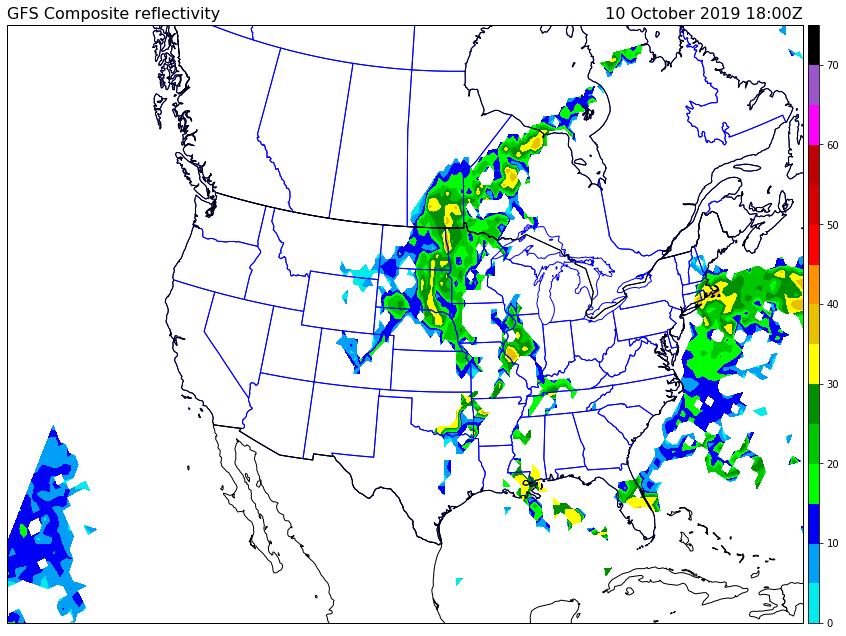

In [118]:
# Create new figure
fig = plt.figure(figsize=(17., 11.))

add_metpy_logo(fig, 30, 1000, size='small')

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)

#Set the lat and lon boundaries
ax.set_extent(extent, datacrs)

# Add state boundaries to plot
ax.add_feature(states_provinces, edgecolor='blue', linewidth=1)

# Add country borders to plot
ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Plot Title
plt.title(product_name+" "+title_name,loc='left',fontsize=16)

# Grab file time any of the downloaded variables
# Grab file time any of the downloaded variables
time_var = data.variables[find_time_var(data.variables['Composite_reflectivity_entire_atmosphere'])]

# Convert number of hours since the reference time into an actual date
time_date = num2date(time_var[:].squeeze(), time_var.units)
# time_final will be a datetime object, so we can manipulate it, but need it as a string, See below:
plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_date),loc='right',fontsize=16)

RADAR_levs = np.arange(0,80,5)
cs = ax.contourf(lon,lat,RADAR,RADAR_levs, cmap=mycmap,transform=datacrs)

cbar = plt.colorbar(cs, orientation='vertical',pad=0.005,aspect=50)

print(time_final)
#plt.savefig(im_save_path+var_name+"_"+time_final+".png",bbox_inches="tight")

<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>--------------------------------------------End-------------------------------------------------------</h2>|

# Make a function to grab the plot simply based off times and image save path

* Currently set up tp grab radar reflectivity (GFS, RAP, GEFS, etc.) and Mslp with additional plotting of Highs/Lows

In [108]:
def Map(time,savepath,plt_show=False):
    
    """
    Required Args- 
    time: datetime object is needed to call query for data
    
    savepath: local path for saved plot
    
    Optional Args - 
    plt_show: 
       if True - show the figure
       if False - close the figure
    
    """
    ################################################################
    # Que up the subset call to get a selction of the data
    subset = ds.subset()

    # Query to the server for the subset
    query_data = subset.query()
    # Set inclusions for the lat/lon data
    query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

    # Allow for NetCDF files
    query_data.accept('netcdf4')

    # Query the time (datetime object) desired
    print(time)
    query_data.time(time)

    # Query desired variables
    # check out appropriate names and levels here:
    # 
    query_data.variables("MSLP_Eta_model_reduction_msl","Composite_reflectivity_entire_atmosphere").add_lonlat()

    # Send query to seerver and attempt to retreive data
    data = subset.get_data(query_data)


    ################################################################
    # Now that we have the data, we can assign variables and metadata to arrays 

    EMSL = data.variables["MSLP_Eta_model_reduction_msl"][:] * units.Pa
    # NAM or RAP version
    #EMSL = data.variables['Pressure_reduced_to_MSL_msl'][:] * units.Pa
    EMSL.ito('hPa')
    
    mslp = gaussian_filter(EMSL[0], sigma=3.0)
    
    RADAR = data.variables["Composite_reflectivity_entire_atmosphere"][:].squeeze()
    RADAR = np.ma.masked_where(RADAR < 1,RADAR) # limit radar values to above 1

    # THe lat/lon data come as 2-d data; this squeezes the data into 1-d arrays
    lat = data.variables['lat'][:].squeeze()
    lon = data.variables['lon'][:].squeeze()

    ################################################################
    # Grab file time any of the downloaded variables
    time_var = data.variables[find_time_var(data.variables['MSLP_Eta_model_reduction_msl'])]

    # Convert number of hours since the reference time into an actual date
    time_date = num2date(time_var[:].squeeze(), time_var.units)
    # time_final will be a datetime object, so we can manipulate it, but need it as a string, See below:
    #print(time_date)
    
    #-----------------------------------------------------------
    # Stupid way of naming the file name extension but it works...
    time_date = str(time_date)
    time_final = time_date[:-3]
    time_final = str(time_final).replace("-","_")
    time_final = str(time_final).replace(" ","_")
    time_final = str(time_final).replace(":","")
    time_final = time_final+"Z"
    #-----------------------------------------------------------
    
    ################################################################
    # Grab variables
    
    # Set name for saved file extension
    #var_name = data.variables['Composite_reflectivity_entire_atmosphere'].Grib2_Parameter_Name
    #var_name = var_name.replace(" ","_")
    var_name = "Sim_Radar"
    
    #var_name2 = data.variables['MSLP_Eta_model_reduction_msl'].Grib2_Parameter_Name
    #var_name2 = var_name2.replace(" ","_")
    var_name2 = "mslp"

    ################################################################  
    # Set up the figure and plot data to it
    
    #--------------------------------------------------------------
    # Create new figure
    fig = plt.figure(figsize=(17., 11.))

    add_metpy_logo(fig, 30, 1000, size='small')

    # Add the map and set the extent
    ax = plt.subplot(111, projection=plotcrs)

    #Set the lat and lon boundaries
    ax.set_extent(extent, datacrs)

    # Add state boundaries to plot
    ax.add_feature(states_provinces, edgecolor='blue', linewidth=1)

    # Add country borders to plot
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)
    #--------------------------------------------------------------
    
    #--------------------------------------------------------------    
    # Plot Title - commented out: using titel in image (code near end below)
    #plt.title('RAP Forecast Refelctivity (dbz)',loc='left',fontsize=16)
    #plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)
    #--------------------------------------------------------------    
    
    #--------------------------------------------------------------
    # Set Radar plotting levels
    RADAR_levs = np.arange(0,81,1)
    mslp_levs = np.arange(980,1030,4)
    #--------------------------------------------------------------
    
    #--------------------------------------------------------------
    # Plot data
    cs = ax.contourf(lon,lat,RADAR,RADAR_levs, cmap=mycmap,transform=datacrs)
    cs2 = ax.contour(lon,lat,mslp,mslp_levs,colors='k',transform=datacrs, 
                   inewidths=1.25,
                 linestyles='solid')
    
    kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
         
    
    plt.clabel(cs2, **kw_clabels)
    
    plot_maxmin_points(ax,lon, lat, mslp, 'max', 50, symbol='H', color='b',  transform=datacrs)
    plot_maxmin_points(ax,lon, lat, mslp, 'min', 25, symbol='L', color='r', transform=datacrs)
    
    # plot colorbar
    cbar = plt.colorbar(cs, orientation='vertical',pad=0.005,aspect=50)
    #--------------------------------------------------------------    
    

    #-----------------------------------------------------------
    # Stupid way of naming the title but it works...
    plot_time_final = num2date(time_var[:].squeeze(), time_var.units)
    #print(str(plot_time_final))
    plot_time_final = str(plot_time_final)

    plot_time_final = plot_time_final[:-3]
    plot_time_final = plot_time_final.replace(":","")
    #-----------------------------------------------------------
    
    # Plot the file time name to the right bottom corner
    text_time = ax.text(.995, 0.01, 
        str(plot_time_final)+"Z",
        horizontalalignment='right', transform=ax.transAxes,
        color='white', fontsize=15, weight='bold')
    
    # Plot the Model name to the left bottom corner
    text_time2 = ax.text(0.005, 0.01, 
            product_name+"\nSimulated Radar (dbz) and Mslp",
            horizontalalignment='left', transform=ax.transAxes,
            color='white', fontsize=15, weight='bold')

    # outline the letters to make it pop a bit more
    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time.set_path_effects(outline_effect)
    text_time2.set_path_effects(outline_effect)

    # Save the figure
    plt.savefig(savepath+product_name+"_"+var_name+"_"+var_name2+"_"+time_final+".png",bbox_inches="tight")
    
    if plt_show == True:
        # Comment out if running loops for plotting and don't want to see every image
        plt.show()
    else:
        # Close the figure
        plt.close(fig)

In [103]:
im_save_path,now

('C://Users//admin/Desktop/Weather_Blog/10_10/',
 datetime.datetime(2019, 10, 10, 12, 0))

In [109]:
for i in forecast_times:    
    Map(i,im_save_path)

2019-10-10 18:00:00
2019-10-10 21:00:00
2019-10-11 00:00:00
2019-10-11 03:00:00
2019-10-11 06:00:00
2019-10-11 09:00:00
2019-10-11 12:00:00
2019-10-11 15:00:00
2019-10-11 18:00:00
